# Understand student performance data set and fitting initial hierarchical models

_**Abstract**_: 

My research project aims to build parametric models with high interpretability on EdTech datasets. In my proposal, I proposed **hierarchical models** as a good way to both understand and predict student performance based on features collected using EdTech systems. 

My previous 2 weeks of project work focused on _**understand my dataset and build a hierarchical model with it**_. In this immediate milestone, I will walk through my dataset, my model building process and some initial results. The initial results are exclusively focused on out-of-sample accuracies because I want to demonstrate that eventhough hierarchical models are parametric, they could perform on par with black-box models such as Random Forest and Boosted Decision Tree.


## Summary
I will first describe the data and quickly explore the data.  Next, I will try various visualizations which reveal some interesting thoughts. We then will try tree-based machine learning models to see what accuracy we could get with black-box models. Finally, we will try to fit a hierarchical logistic model with this data as alternative to tree-based models and compare the accuracy.

This notebook is long, so here is the layout of points covered:

* [Data overview](#data)
* [Data exploration](#exploration)
* [Tree-based models](#traditional)
* [Hierarchical models](#hierarchical)
     - [Motivation recap](#recap)
     - [Hierarchical logistic model](#hier_logit)
     - [Prediction accuracy](#prediction)     

<a id='generalnotes'></a>

<a id='data'></a>
## Data overview
This is an educational data set which is collected from learning management system (LMS) 
using a learner activity tracker tool, which called experience API (xAPI). The xAPI is a component of the training and learning architecture (TLA) that enables to monitor learning progress like reading an article or watching a training video. 

The experience API helps the learning activity providers to determine the learner, activity and objects that describe a learning experience. The dataset consists of 480 student records and 16 features. 

### Features
The features are classified into three major categories: 
* Demographic features such as gender and nationality. 
* Academic background features such as educational stage, grade Level and section. 
* Behavioral features such as raised hand on class, opening resources, answering survey by parents, and school satisfaction.

### Categorical summary
The dataset consists of 305 males and 175 females. The students come from different origins such as 179 students are from Kuwait, 172 students are from Jordan, 28 students from Palestine, 22 students are from Iraq, 17 students from Lebanon, 12 students from Tunis, 11 students from Saudi Arabia, 9 students from Egypt, 7 students from Syria, 6 students from USA, Iran and Libya, 4 students from Morocco and one student from Venezuela.

### Relevant Papers:
Amrieh, E. A., Hamtini, T., & Aljarah, I. (2016). Mining Educational Data to Predict Student’s academic Performance using Ensemble Methods. International Journal of Database Theory and Application, 9(8), 119-136.

Amrieh, E. A., Hamtini, T., & Aljarah, I. (2015, November). Preprocessing and analyzing educational data set using X-API for improving student's performance. In Applied Electrical Engineering and Computing Technologies (AEECT), 2015 IEEE Jordan Conference on (pp. 1-5). IEEE.

<a id='exploration'></a>
## Data Exploration
### Data clean-up and preparation
We have no missing values, which saves us a lot of time and uncertainty in making assumptions.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.options.display.max_columns = None

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')
import pystan

In [19]:
# set my publication default - https://matplotlib.org/users/customizing.html
def defaultPlotting(): 
    sns.set(rc={'figure.figsize':(4, 3),"font.size":15,
                "axes.titlesize":14, "axes.labelsize": 14, 
                "xtick.labelsize": 12, "ytick.labelsize": 12,
                "font.weight": 'bold', "axes.titleweight":'bold', 
                "axes.labelweight":'bold',
                "figure.titleweight": 'bold'},
            style="white")
defaultPlotting()

In [20]:
# Import data and start exploratory data analysis
df = pd.read_csv('../data/xAPI-Edu-Data.csv')

Some stats to get a general feeling of the data:

In [21]:
print "Size:", df.shape 
df.head(2)

Size: (480, 17)


,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M


Some info

In [22]:
# Some of the columns seem to have random capitalizations 
df.rename(index=str, columns={'gender':'Gender', 'NationalITy':'Nationality',
                               'raisedhands':'RaisedHands', 'VisITedResources':'VisitedResources'},
                               inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 480 entries, 0 to 479
Data columns (total 17 columns):
Gender                      480 non-null object
Nationality                 480 non-null object
PlaceofBirth                480 non-null object
StageID                     480 non-null object
GradeID                     480 non-null object
SectionID                   480 non-null object
Topic                       480 non-null object
Semester                    480 non-null object
Relation                    480 non-null object
RaisedHands                 480 non-null int64
VisitedResources            480 non-null int64
AnnouncementsView           480 non-null int64
Discussion                  480 non-null int64
ParentAnsweringSurvey       480 non-null object
ParentschoolSatisfaction    480 non-null object
StudentAbsenceDays          480 non-null object
Class                       480 non-null object
dtypes: int64(4), object(13)
memory usage: 67.5+ KB


Use the `merge` method to combine home- and county-level information in a single DataFrame.

This is the data we deal with. Hierarchy is defined by county. target/dependent variable is 'activity'
'Uppm' is the Uranium level at county level, one of the main predictors.


Save figures

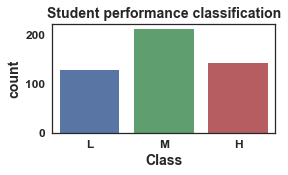

In [27]:
out_dir = '../paper/latex/figures/'
plt.clf(); ax = plt.subplot(111); fig = plt.gcf()
fig.set_size_inches(4, 2, forward=True)

cls = sns.countplot(x='Class', data=df, order=['L', 'M', 'H'])
cls.set(title='Student performance classification')
plt.savefig(out_dir + 'y_count.png', dpi=600, bbox_inches='tight')

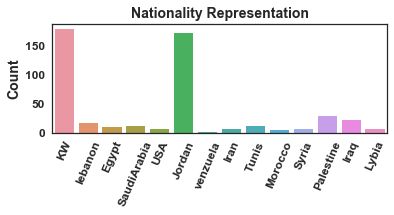

In [37]:
plt.clf(); ax = plt.subplot(111); fig = plt.gcf()
fig.set_size_inches(6, 2, forward=True)

nat = sns.countplot(x='Nationality', data=df)
nat.set(xlabel='', ylabel='Count', title='Nationality Representation')
plt.setp(nat.get_xticklabels(), rotation=67)

plt.savefig(out_dir + 'nationality_bar.png', dpi=600, bbox_inches='tight')

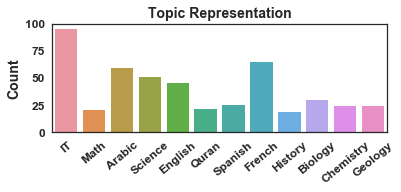

In [33]:
plt.clf(); ax = plt.subplot(111); fig = plt.gcf()
fig.set_size_inches(6, 2, forward=True)
topic = sns.countplot(x='Topic', data=df)
topic.set(xlabel='', ylabel='Count', title='Topic Representation')

_ = plt.setp(topic.get_xticklabels(), rotation=40)
plt.savefig(out_dir + 'topic_bar.png', dpi=600, bbox_inches='tight')

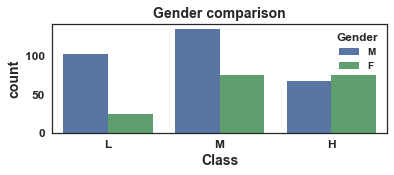

In [54]:
plt.clf(); ax = plt.subplot(111); fig = plt.gcf()
fig.set_size_inches(6, 2, forward=True)
gen = sns.countplot(x='Class', hue='Gender', data=df, order=['L', 'M', 'H'])
_ = gen.set(title='Gender comparison')

plt.savefig(out_dir + 'gender_outcome.png', dpi=600, bbox_inches='tight')

In [ ]:
# basic data exploratory tasks
fig, axarr  = plt.subplots(2, 2, figsize=(10,8),)

cls = sns.countplot(x='Class',       data=df, ax=axarr[0,0])
cls.set(title='Occurences per class')
nat = sns.countplot(x='Nationality', data=df, ax=axarr[0,1])
nat.set(xlabel='', ylabel='Count', title='Nationality Representation')

plt.setp(nat.get_xticklabels(), rotation=60)


topic = sns.countplot(x='Topic', data=df, ax=axarr[1,0])
topic.set(xlabel='Topic', ylabel='Count', title='Topic Representation')

_ = plt.setp(topic.get_xticklabels(), rotation=40)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

gen = sns.countplot(x='Class', hue='Gender', data=df, order=['L', 'M', 'H'], 
              ax=axarr[1,1])
_ = gen.set(title='Gender comparison')

A few conclusions on first look:
* The dataset is quite balanced. (first chart)  
* Most of our students are from Kuwait or Jordan. This was already mentioned in the description of the dataset, but it's nice to provide a visual.
* Topic representations are pretty good, but IT seems to dominate
* It looks like women performed better than men on average. Would the amount of visited resources in the online environment influence the final grade?


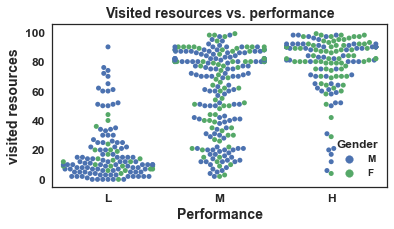

In [55]:
plt.clf(); ax = plt.subplot(111); fig = plt.gcf()
fig.set_size_inches(6, 3, forward=True)

plot = sns.swarmplot(x='Class', y='VisitedResources', hue='Gender', order=['L', 'M', 'H'], 
              data=df)
plot.set(xlabel='Performance', ylabel='visited resources', title='Visited resources vs. performance')

plt.savefig(out_dir + 'vresources_outcome.png', dpi=600, bbox_inches='tight')

This swarm plot shows us that students who received a lower grade (L) visited way fever resources than students that scored a M or H grade. Additionally, women who received a high mark (H) almost exclusively visited a lot of the online resources.

Let's dig a little bit deeper into other numerical variables.

/Users/cuongnguyen/miniconda2/envs/stan27/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color', 'lw', 'marker', 'label'
  s)


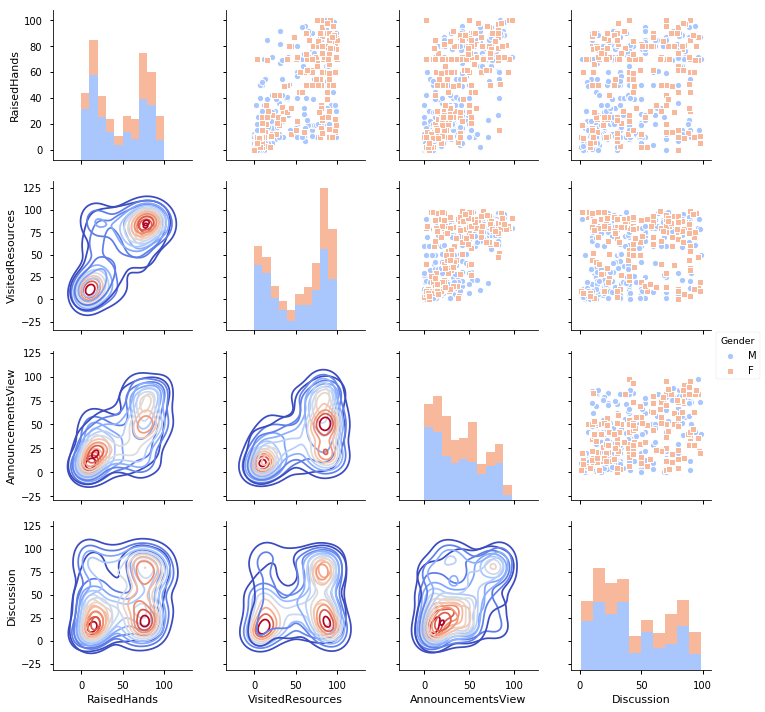

In [9]:
# Pairgrid, exploring our numerical variables
grd = sns.PairGrid(df, hue='Gender', palette='coolwarm', hue_kws={'marker': ['o', 's']})
grd = grd.map_diag(plt.hist)
grd = grd.map_upper(plt.scatter, linewidths=1, edgecolor='w', s=40)
grd = grd.map_lower(sns.kdeplot, lw=3, legend=False, cmap='coolwarm')
grd = grd.add_legend()

The plots show there are any specific relationships or patterns in the numerical data. However, when exploring the visited resources again we see that females generally visit more resources - clearly visible in the histogram.

<a id='traditional'></a>
## Tree-based models
Now we get to the model building bit. We will start by encoding our categorical variables and splitting the data into a train and test set.

In [10]:
X = df.drop('Class', axis=1)
y = df['Class']

# Encoding our categorical columns in X
labelEncoder = LabelEncoder()
cat_columns = X.dtypes.pipe(lambda x: x[x == 'object']).index
for col in cat_columns:
    X[col] = labelEncoder.fit_transform(X[col])

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Let's try decision tree and random forest:

In [11]:
keys = []
scores = []
models = {'Decision Tree': DecisionTreeClassifier(),
          'Random Forest': RandomForestClassifier(n_estimators=300, random_state=42)}

for k,v in models.items():
    mod = v
    mod.fit(X_train, y_train)
    pred = mod.predict(X_test)
    print('Results for: ' + str(k) + '\n')
    print(confusion_matrix(y_test, pred))
    print(classification_report(y_test, pred))
    acc = accuracy_score(y_test, pred)
    print("accuracy is "+ str(acc)) 
    print('\n' + '\n')
    keys.append(k)
    scores.append(acc)
    table = pd.DataFrame({'model':keys, 'accuracy score':scores})

print(table)


Results for: Random Forest

[[21  0  7]
 [ 0 31  3]
 [ 5  4 49]]
             precision    recall  f1-score   support

          H       0.81      0.75      0.78        28
          L       0.89      0.91      0.90        34
          M       0.83      0.84      0.84        58

avg / total       0.84      0.84      0.84       120

accuracy is 0.8416666666666667



Results for: Decision Tree

[[21  0  7]
 [ 0 28  6]
 [ 7  8 43]]
             precision    recall  f1-score   support

          H       0.75      0.75      0.75        28
          L       0.78      0.82      0.80        34
          M       0.77      0.74      0.75        58

avg / total       0.77      0.77      0.77       120

accuracy is 0.7666666666666667



   accuracy score          model
0        0.841667  Random Forest
1        0.766667  Decision Tree


So, basic tree models (Random Forest) without any params tunning should get us to 84% Accuracy, which is inline with what Amrieh et. at. get in their papers.

For hierarchical models, this accuracy should be the goal.

<a id='hierarchical'></a>
## Hierarchical models
<a id='hier_logistic'></a>
[Motivation of why we should try Hierarchical models on this dataset is provided in **my 1st milestone.**](http://nbviewer.jupyter.org/github/nguyentu1602/et_submissions/blob/master/milestone1/notebook/Intermediate%20Milestone%201.ipynb)


For a very quick recap, in a hierarchical model, parameters are viewed as a sample from a population distribution of parameters. Thus, we view them as being neither entirely different or exactly the same. This is ***parital pooling***.

![hierarchical](http://f.cl.ly/items/1B3U223i002y3V2W3r0W/Screen%20Shot%202013-10-10%20at%208.25.05%20AM.png)

<a id='hier_logistic'></a>
## Hierarchical logistic model
In our example, the outcomes are categorical, so we need to fit a logistic model on the probabilities of student performance outcome.

Multiple hierarchies were tried, but for demonstration purpose, let's do just one level here. We'll used `Topic` where group-level parameters are grouped by a normal distribution. There are several reasons we use `Topic` here, but the main one is that hierarchical model only add value when the number of pooled groups >= 6 as suggested in [Gelman (2003).](http://www.stat.columbia.edu/~gelman/arm/)

In [85]:
# show cols one more time
df.columns

Index([u'Gender', u'Nationality', u'PlaceofBirth', u'StageID', u'GradeID',
       u'SectionID', u'Topic', u'Semester', u'Relation', u'RaisedHands',
       u'VisitedResources', u'AnnouncementsView', u'Discussion',
       u'ParentAnsweringSurvey', u'ParentschoolSatisfaction',
       u'StudentAbsenceDays', u'Class', u'TopicCode'],
      dtype='object')

In [13]:
# make a new column to map the Topic from ABCD to 0,1,2,3
df_old = df
dgroups = df.Topic.unique()
glookup = dict(zip(dgroups, range(len(dgroups))))
glookup

groups = df['TopicCode'] = df.Topic.replace(glookup).values 

In [63]:
# Data preparation
X = df.drop(['Class', 'TopicCode', 'Topic' ], axis=1)
X = pd.get_dummies(X,drop_first=True) # one-hot everything

y = df['Class']
y[y == 'M'] = 'H' # simplify signal
y = np.array((y == 'H').values, dtype=np.int)

# Train Test Split 
# TODO: correctly split the `groups` variable above here by using the same random_state

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
_, _, groups_train, groups_test  = train_test_split(X, groups, test_size=0.25, random_state=42)


/Users/cuongnguyen/miniconda2/envs/stan27/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [84]:
# print( X.columns.values)
X.head(2)

,RaisedHands,VisitedResources,AnnouncementsView,Discussion,Gender_M,Nationality_Iran,Nationality_Iraq,Nationality_Jordan,Nationality_KW,Nationality_Lybia,Nationality_Morocco,Nationality_Palestine,Nationality_SaudiArabia,Nationality_Syria,Nationality_Tunis,Nationality_USA,Nationality_lebanon,Nationality_venzuela,PlaceofBirth_Iran,PlaceofBirth_Iraq,PlaceofBirth_Jordan,PlaceofBirth_KuwaIT,PlaceofBirth_Lybia,PlaceofBirth_Morocco,PlaceofBirth_Palestine,PlaceofBirth_SaudiArabia,PlaceofBirth_Syria,PlaceofBirth_Tunis,PlaceofBirth_USA,PlaceofBirth_lebanon,PlaceofBirth_venzuela,StageID_MiddleSchool,StageID_lowerlevel,GradeID_G-04,GradeID_G-05,GradeID_G-06,GradeID_G-07,GradeID_G-08,GradeID_G-09,GradeID_G-10,GradeID_G-11,GradeID_G-12,SectionID_B,SectionID_C,Semester_S,Relation_Mum,ParentAnsweringSurvey_Yes,ParentschoolSatisfaction_Good,StudentAbsenceDays_Under-7
0,15,16,2,20,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
1,20,20,3,25,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1


Now we start to specify the actual model here - notice we leave the prior pretty uninformative at `Normal(0,100)`. The `generated quantities` block is used to run the test data pass the model.

In [70]:
# Now how do I fit a hierarchical logistic model here?
# check section 9.9 in the STAN manual for instructions
hier_log_reg_model = """data {
    // number of observations
    int<lower=0> N;
    
    // number of Topic
    int<lower=1> L;
    
    // target vector
    int y[N];
    
    // number of predictors - equivalent to D in the Manual
    int K;
    
    // features matrix
    matrix[N, K] X;
    
    // what is ll? actual vector of ll
    int<lower=1, upper=L> ll[N];
    
    // prediction block
    int<lower=0> N_new;
    matrix[N_new, K] X_new;
    int<lower=1, upper=L> ll_new[N_new];
}
transformed data {
}
parameters {
  // regression coefficient vector
  real mu[K];
  real<lower=0> sigma[K];  
  vector[K] beta[L];
}

model {    
    for (d in 1:K){
        mu[d] ~ normal(0, 100);
        for (l in 1:L){
            beta[l, d] ~ normal(mu[d], sigma[d]);
        }
    }
    
    for(n in 1:N) {
        y[n] ~ bernoulli_logit(X[n] * beta[ll[n]]);
  }
}
// This block will do the prediction for us
generated quantities {
      vector[N_new] y_new;
      for (n in 1:N_new)
        y_new[n] = bernoulli_logit_rng(X_new[n] * beta[ll_new[n]]);
    }

"""

# precompile the model object here
sm_hier_lr = pystan.StanModel(model_code=hier_log_reg_model)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c5bfdb04d4e86a6cc175a2ef924c2931 NOW.


In [71]:
# # now make the data specifically to STAN
X_train_sub = X_train

hier_log_reg_dat = {
            'N': len(y_train),
            'y': y_train,
            'll': groups_train + 1,
            'L': len(glookup),  # number of topics
            'K': X_train_sub.shape[1],  # number of predictors
            'X': X_train_sub.values,
            'N_new': len(y_test),
            'X_new': X_test.values,
            'll_new': groups_test + 1,
}

In [72]:
# hier_log_reg_dat
#X_train_sub

In [73]:
# fit the data using the precompiled model object
# Take ~10 mins
fit3 = sm_hier_lr.sampling(data=hier_log_reg_dat, iter=600, chains=2)

Take quite a while to fit this model with Hamiltonian Monte Carlo!

<a id='prediction'></a>
### Prediction accuracy
Now onto the actual out-of-sample accuracy of the Hierarchical model

In [79]:
# extract the fit, which also has the prediction
fit3_sample = fit3.extract(permuted=True) # of type OrderedDict

In [80]:
y_pred_arr = fit3_sample['y_new']
y_pred_prob = y_pred_arr.mean(axis=0)
y_pred = np.array(y_pred_prob > 0.5, dtype=np.int)

In [81]:
print('Results for: ' + 'Hierarchical Model' + '\n')

pred = y_pred
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
acc = accuracy_score(y_test, pred)
print("accuracy is "+ str(acc)) 
print('\n' + '\n')

Results for: Hierarchical Model

[[27  7]
 [ 3 83]]
             precision    recall  f1-score   support

          0       0.90      0.79      0.84        34
          1       0.92      0.97      0.94        86

avg / total       0.92      0.92      0.92       120

accuracy is 0.9166666666666666





How does it compare to other models?

In [82]:
# append into the original table with other
keys.append('Hierarchical Logistic')
scores.append(acc)
table = pd.DataFrame({'model':keys, 'accuracy score':scores})

print(table)

   accuracy score                  model
0        0.841667          Random Forest
1        0.766667          Decision Tree
2        0.916667  Hierarchical Logistic


So, in conclusion, hierarchical model does pretty well in comparison to the blackbox models!
Now, the comparision is not really fair for the tree models, because I didn't manage account for the ordinal outcomes, so I merged two classes `[M, H]` into one and predict that against `L`. However, in the final paper, I will address this issue.

## References

Gelman, A., & Hill, J. (2006). Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.). Cambridge University Press.

Gelman, A. (2006). Multilevel (Hierarchical) modeling: what it can and cannot do. Technometrics, 48(3), 432–435.